In [419]:
import os
import numpy as np
import urllib
import operator

%matplotlib inline
import matplotlib.pyplot as plt

import skimage.io
import skimage.transform

from caffe2.python import core, workspace, models
from caffe2.proto import caffe2_pb2

In [420]:
# !python -m caffe2.python.models.download -i squeezenet

In [421]:
CAFE_MODEL_DIRECTORY = '' # it's in my current directory
SQUEZZE_NET_SUB = 'squeezenet'
INIT_NET_PB = os.path.join(CAFE_MODEL_DIRECTORY, SQUEZZE_NET_SUB, 'init_net.pb')
PREDICT_NET_PB = os.path.join(CAFE_MODEL_DIRECTORY, SQUEZZE_NET_SUB, 'predict_net.pb')
IMAGE_SIZE = 230

In [422]:
if not os.path.exists(INIT_NET_PB):
    print('{} not found.'.format(INIT_NET_PB))
else:
    if not os.path.exists(PREDICT_NET_PB):
        print('{} not found.'.format(PREDICT_NET_PB))
    else:
        print('All files found!')

All files found!


In [423]:
MEAN_FILE = 'data/ilsvrc_2012_mean.npy'

In [424]:
mean_arr = np.load(MEAN_FILE)
mean_arr.shape

(3, 256, 256)

In [425]:
# calculate mean RGB values for the 3 channels in a color image
mean_arr = mean_arr.mean(1).mean(1)
mean_arr.shape

(3,)

In [426]:
mean_arr

array([104.00698793, 116.66876762, 122.67891434])

In [427]:
# mean value needs to reshaped to a 3-d matrix

mean = mean_arr[:, np.newaxis, np.newaxis]
print('mean shape:', mean.shape)
print('mean:', mean)

mean shape: (3, 1, 1)
mean: [[[104.00698793]]

 [[116.66876762]]

 [[122.67891434]]]


In [428]:
ALEX_NET_CODES = './data/alex_net_codes.txt'

In [429]:
label_lookup = []

with open(ALEX_NET_CODES) as f:
    lines = f.readlines()
    
    for line in lines:
        if ':' in line:
            code, result = line.split(':')
            code = code.strip()
            result = result.replace("'","")
            #print(code)
            
            if code[1:].isdigit():
                label_lookup.append(result.split(",")[0][1:].strip())
                
    print(label_lookup[:30])

['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'European fire salamander', 'common newt', 'eft', 'spotted salamander', 'axolotl']


In [430]:
def crop_center(img, cropx, cropy):
    height, width, channel = img.shape
    
    start_width = width// 2 - (cropx // 2)
    start_height = height//2 - (cropy // 2)
    
    return img[start_height:start_height + cropy, start_width:start_width + cropx]

In [431]:
def rescale_img(img, input_height, input_width):
    
    aspect_ratio = img.shape[1] / float(img.shape[0])
    
      # if there are equal we do'nt do anything
    if (aspect_ratio == 1):
        img_scaled =skimage.transform.resize(img, (input_width, input_height))

    # if image is wide -- landscape orientation
    if (aspect_ratio > 1):
        rescaled_height = int(aspect_ratio * input_height)
        img_scaled =skimage.transform.resize(img, (input_width, rescaled_height))
        
    # if image is tall -- portraite orientation
    if (aspect_ratio < 1):
        rescaled_width = int(input_width / aspect_ratio)
        img_scaled =skimage.transform.resize(img, (rescaled_width, input_height))
        
    return img_scaled

In [432]:
def display_image(img, title=None):
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis('on')
    title = title + ' \n shape: ' + str(img.shape)
    
    plt.title(title)
    plt.show()

In [433]:
TEST_IMAGE = 'https://upload.wikimedia.org/wikipedia/commons/6/6e/Golde33443.jpg'
#TEST_IMAGE = 'https://upload.wikimedia.org/wikipedia/commons/c/c7/Lemon-Whole-Split.jpg'

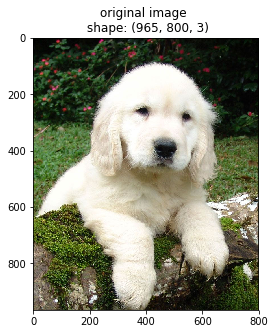

In [434]:
img = skimage.img_as_float(skimage.io.imread(TEST_IMAGE)).astype(np.float32)
display_image(img,'original image')

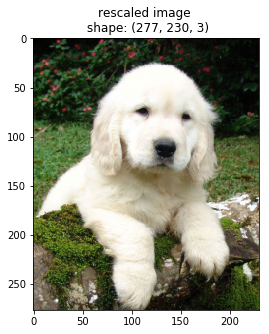

(277, 230, 3)


In [435]:
img_rescaled = rescale_img(img, IMAGE_SIZE, IMAGE_SIZE)
display_image(img_rescaled,'rescaled image')
print(img_rescaled.shape)

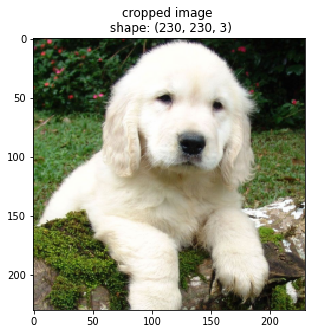

In [436]:
img_crop = crop_center(img_rescaled, IMAGE_SIZE, IMAGE_SIZE)
display_image(img_crop,'cropped image')

In [437]:
img_crop.shape

(230, 230, 3)

In [438]:
# conevrt image to CHW format
img_swap = img_crop.swapaxes(1,2).swapaxes(0,1)
print(img_swap.shape)

(3, 230, 230)


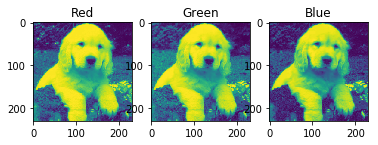

In [439]:
plt.figure()

rgb_channels = ['Red', 'Green', 'Blue']

for i in range (len(rgb_channels)):
    plt.subplot(1,3, i+1)
    plt.imshow(img_swap[i])
    plt.title(rgb_channels[i])

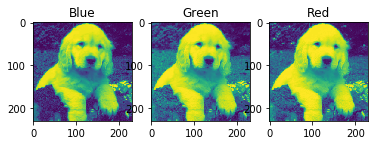

In [440]:
# then we can convert it into BGR -- Caffe2 expects to receive image in BGR format
img_swam_bgr = img_swap[(2,1,0), :, :]
plt.figure()

rgb_channels = ['Blue', 'Green', 'Red']

for i in range (len(rgb_channels)):
    plt.subplot(1,3, i+1)
    plt.imshow(img_swam_bgr[i])
    plt.title(rgb_channels[i])

In [441]:
img_swam_bgr[:1:1]

array([[[0.04762365, 0.03260719, 0.01800879, ..., 0.01874769,
         0.01599837, 0.01472552],
        [0.07752745, 0.0833146 , 0.0669703 , ..., 0.01558904,
         0.01982205, 0.02845049],
        [0.07139986, 0.08225582, 0.08025064, ..., 0.01907336,
         0.02654627, 0.04129128],
        ...,
        [0.37786079, 0.42265214, 0.42142285, ..., 0.09198634,
         0.13293171, 0.11667089],
        [0.36163868, 0.40335394, 0.40995411, ..., 0.08627565,
         0.06924318, 0.05947079],
        [0.37471577, 0.4251761 , 0.4578223 , ..., 0.10287615,
         0.08990132, 0.05169222]]])

In [442]:
img_normalized = img_swam_bgr * 255 - mean

In [443]:
img_normalized[:1:1]

array([[[ -91.86295671,  -95.69215418,  -99.4147457 , ...,
          -99.22632579,  -99.92740386, -100.25198061],
        [ -84.23748855,  -82.76176434,  -86.92956176, ...,
         -100.03178375,  -98.95236559,  -96.75211385],
        [ -85.80002451,  -83.0317547 ,  -83.5430742 , ...,
          -99.14328018,  -97.23768819,  -93.4777124 ],
        ...,
        [  -7.65248648,    3.76930734,    3.4558376 , ...,
          -80.55047191,  -70.10940267,  -74.25591137],
        [ -11.78912551,   -1.15173251,    0.53131088, ...,
          -82.00669819,  -86.34997723,  -88.84193719],
        [  -8.45446695,    4.4129168 ,   12.73769935, ...,
          -77.77356904,  -81.08215252,  -90.82547196]]])

In [444]:
img_normalized.shape

(3, 230, 230)

In [445]:
img_final = img_normalized[np.newaxis, :, :, :].astype(np.float32)

In [446]:
print('image is ready to be used as input', img_final.shape)

image is ready to be used as input (1, 3, 230, 230)


In [447]:
with open(INIT_NET_PB, 'rb') as f:
    init_net = f.read()
    
with open(PREDICT_NET_PB, 'rb') as f:
    predict_net = f.read()

In [448]:
p = workspace.Predictor(init_net, predict_net)

In [449]:
results = p.run({'data': img_final})

In [450]:
results = np.asarray(results)
print('results shape', results.shape)

results shape (1, 1, 1000, 1, 1)


In [451]:
preds = np.squeeze(results)
print('prediction shape', preds.shape)

prediction shape (1000,)


In [452]:
current_prediction_score, current_confidence_score = max(enumerate(preds), key= operator.itemgetter(1))

In [453]:
print('Prediction:', current_prediction_score)
print('Confidence:', current_confidence_score)

Prediction: 257
Confidence: 0.58812124


In [454]:
label_lookup[current_prediction_score]

'Great Pyrenees'

In [455]:
top5_pred = np.argpartition(preds, -5)[:5]

In [456]:
top5_pred

array([300, 499, 986,   3, 981])

In [459]:
for i in top5_pred:
    print('Prediction:',label_lookup[i],', Confidence:', (preds[i]*100))

Prediction: tiger beetle , Confidence: 2.8992958402669438e-15
Prediction: cleaver , Confidence: 2.2885776737583048e-14
Prediction: yellow ladys slipper , Confidence: 3.35441590724954e-14
Prediction: tiger shark , Confidence: 1.8850837355152662e-14
Prediction: ballplayer , Confidence: 5.975514628600445e-14
